**Judul Tugas Besar:** Deteksi Kolam Renang dalam Manajemen Bencana Kebakaran Hutan \
**Kelas:** IF-42-GAB \
**Kelompok:** 3 \
**Anggota Kelompok**: \

1.   Muhamad Farell Ambiar (1301184262) 
2.   Mohammad Daffa Haris (1301180355)
3.   Ryan Adeputra Sutopo (1301180297)

In [1]:
!pip install pycocotools>=2.0.2 > /dev/null
!pip install timm>=0.3.2 > /dev/null
!pip install omegaconf>=2.0 > /dev/null
!pip install ensemble-boxes > /dev/null
!pip install effdet > /dev/null
!pip install -U albumentations

     |████████████████████████████████| 102 kB 13.1 MB/s 
     |████████████████████████████████| 47.7 MB 2.5 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
!git clone https://github.com/alleFarell/Datasets-ML.git

Cloning into 'Datasets-ML'...
remote: Enumerating objects: 3676, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 3676 (delta 9), reused 43 (delta 9), pack-reused 3633
Receiving objects: 100% (3676/3676), 884.16 MiB | 25.98 MiB/s, done.
Resolving deltas: 100% (1230/1230), done.
Checking out files: 100% (3653/3653), done.


In [3]:
!pip uninstall opencv-python-headless

Found existing installation: opencv-python-headless 4.5.5.62
Uninstalling opencv-python-headless-4.5.5.62:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.62.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-64ac49e1.so.58.91.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-4b79e479.so.58.45.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-805734e8.so.56.51.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-018b8c17.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dist

In [4]:
!pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 1.6 MB/s 


In [ ]:
import sys
import torch
import os
import warnings
import time
import cv2
import pandas as pd
import numpy as np
import gc
from tqdm.auto import tqdm
from datetime import datetime
from collections import Counter
from glob import glob

from ensemble_boxes import weighted_boxes_fusion
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold, train_test_split
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.utils.data.dataloader import default_collate

from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet import create_model, unwrap_bench, create_loader, create_dataset, create_evaluator, create_model_from_config
from effdet.data import resolve_input_config, SkipSubset
from effdet.anchors import Anchors, AnchorLabeler
from timm.models import resume_checkpoint, load_checkpoint
#from timm.utils import *
from timm.optim import create_optimizer
from timm.scheduler import create_scheduler

import random

In [ ]:
#Variabel Global yang digunakan
TRAIN = True
TRAIN_ROOT_PATH = 'Datasets-ML/Aerial Dataset Swimming Pool/CANNES_TILES_512x512_PNG/CANNES_TILES_512x512_PNG/'
SEED = 42
IMG_SIZE = 512

label2color = [[255, 0, 0]]
viz_labels =  ["pool"]

In [ ]:
# Load csv Setelah proses EDA
df_annotations = pd.read_csv('EDA.csv')
df_annotations['image_path'] = df_annotations['image_id'].map(lambda x:os.path.join(TRAIN_ROOT_PATH, str(x)))

# Memfilter anotasi yang salah atau kolam berenang yang terlalu kecil
df_annotations = df_annotations.drop(df_annotations[(df_annotations['xmin'] == 0) & (df_annotations['xmax'] == 0)].index)
df_annotations = df_annotations.drop(df_annotations[(df_annotations['ymin'] == 0) & (df_annotations['ymax'] == 0)].index)

# Menyimpan kolam renang yang valid
df_annotations = df_annotations[df_annotations['class'] == 'pool']
df_annotations.reset_index(drop=True, inplace=True)
df_annotations['class'] = 1
df_annotations['xmin'] = df_annotations['xmin'] - 1
df_annotations['ymin'] = df_annotations['ymin'] - 1
df_annotations.head(5)

image_id  ...                                         image_path
0  CANNES_TILES_512x512.368.png  ...  Datasets-ML/Aerial Dataset Swimming Pool/CANNE...
1  CANNES_TILES_512x512.110.png  ...  Datasets-ML/Aerial Dataset Swimming Pool/CANNE...
2  CANNES_TILES_512x512.110.png  ...  Datasets-ML/Aerial Dataset Swimming Pool/CANNE...
3   CANNES_TILES_512x512.47.png  ...  Datasets-ML/Aerial Dataset Swimming Pool/CANNE...
4   CANNES_TILES_512x512.47.png  ...  Datasets-ML/Aerial Dataset Swimming Pool/CANNE...

[5 rows x 12 columns]

In [ ]:
image_paths = df_annotations['image_path'].unique()
print("Number of Images :",len(image_paths))
anno_count = df_annotations.shape[0]
print("Number of Annotations:", anno_count)

Number of Images : 1224
Number of Annotations: 3197


In [ ]:
# Seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# Plots
def plot_img(img, size=(18, 18), is_rgb=True, title="", cmap=None):
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=2, size=10, is_rgb=True, title="", cmap=None, img_size=None):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img)
    plt.suptitle(title)
    return fig

def draw_bbox_small(image, box, label, color):   
    alpha = 0
    alpha_text = 0.4
    thickness = 1
    font_size = 0.4
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, font_size, thickness)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height), (box[0]+text_width+2, box[1]),
                (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_text, output, 1 - alpha_text, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                    color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 255, 255), thickness, cv2.LINE_AA)
    return output

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
# Dataset class
class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()
        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.5:
            image, boxes, labels = self.load_image_and_boxes(index)
        else:
            image, boxes, labels = self.load_cutmix_image_and_boxes(index)
        
        ## To prevent ValueError: y_max is less than or equal to y_min for bbox from albumentations bbox_utils
        labels = np.array(labels, dtype=np.int).reshape(len(labels), 1)
        combined = np.hstack((boxes.astype(np.int), labels))
        combined = combined[np.logical_and(combined[:,2] > combined[:,0],
                                                          combined[:,3] > combined[:,1])]
        boxes = combined[:, :4]
        labels = combined[:, 4].tolist()
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.tensor(labels)
        target['image_id'] = torch.tensor([index])
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  ## ymin, xmin, ymax, xmax
                    break
            
            ## Handling case where no valid bboxes are present
            if len(target['boxes'])==0 or i==9:
                return None
            else:
                ## Handling case where augmentation and tensor conversion yields no valid annotations
                try:
                    assert torch.is_tensor(image), f"Invalid image type:{type(image)}"
                    assert torch.is_tensor(target['boxes']), f"Invalid target type:{type(target['boxes'])}"
                except Exception as E:
                    print("Image skipped:", E)
                    return None      

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}', cv2.IMREAD_COLOR).copy()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        labels = records['class'].tolist()
        resize_transform = A.Compose([A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0)], 
                                    p=1.0, 
                                    bbox_params=A.BboxParams(
                                        format='pascal_voc',
                                        min_area=0.1, 
                                        min_visibility=0.1,
                                        label_fields=['labels'])
                                    )

        resized = resize_transform(**{
                'image': image,
                'bboxes': boxes,
                'labels': labels
            })

        resized_bboxes = np.vstack((list(bx) for bx in resized['bboxes']))
        return resized['image'], resized_bboxes, resized['labels']
    
    def load_cutmix_image_and_boxes(self, index, imsize=512):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2

        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []
        result_labels = np.array([], dtype=np.int)

        for i, index in enumerate(indexes):
            image, boxes, labels = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)
            result_labels = np.concatenate((result_labels, labels))

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        index_to_use = np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)
        result_boxes = result_boxes[index_to_use]
        result_labels = result_labels[index_to_use]

        return result_image, result_boxes, result_labels
    

In [ ]:
#  Image transforms
def get_train_transforms():
    return A.Compose(
        [
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                 val_shift_limit=0.2, p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.2, 
                                       contrast_limit=0.2, p=0.9),
        ],p=0.9),
        A.JpegCompression(quality_lower=85, quality_upper=95, p=0.2),
        A.OneOf([
            A.Blur(blur_limit=3, p=1.0),
            A.MedianBlur(blur_limit=3, p=1.0)
            ],p=0.1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1),
        A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
        ToTensorV2(p=1.0)
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [ ]:
class Fitter:
    def __init__(self, model, device, config, fold):
        self.config = config
        self.epoch = 0
        self.fold = fold

        self.base_dir = f'./{config.folder}'
        
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
            
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5
        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = config.OptimizerClass(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        history_dict = {}
        history_dict['epoch'] = []
        history_dict['train_loss'] = []
        history_dict['val_loss'] = []
        history_dict['train_lr'] = []
        
        for e in range(self.config.n_epochs):
            history_dict['epoch'].append(self.epoch)
            lr = self.optimizer.param_groups[0]['lr']
            timestamp = datetime.utcnow().isoformat()
            
            if self.config.verbose:
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss, loss_trend, lr_trend = self.train_epoch(train_loader)
            history_dict['train_loss'].append(loss_trend)
            history_dict['train_lr'].append(lr_trend)
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')
            
            t = time.time()
            summary_loss, loss_trend = self.validation(validation_loader)
            history_dict['val_loss'].append(loss_trend)
            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/fold-{self.fold}-best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                
                try:
                    os.remove(f)
                except:pass
                f = f'{self.base_dir}/fold-{self.fold}-best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin'

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1
        return history_dict

    def train_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        loss_trend = []
        lr_trend = []
        for step, (images, targets, image_ids) in tqdm(enumerate(train_loader), total=len(train_loader)):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )            
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            
            target_res = {}
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            target_res['bbox'] = boxes
            target_res['cls'] = labels
            self.optimizer.zero_grad()
            output = self.model(images, target_res)

            loss = output['loss']
            loss.backward()
            summary_loss.update(loss.detach().item(), self.config.batch_size)
            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

            lr = self.optimizer.param_groups[0]['lr']
            loss_trend.append(summary_loss.avg)
            lr_trend.append(lr)
        return summary_loss, loss_trend, lr_trend
    
    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        loss_trend = []
#        lr_trend = []
        
        for step, (images, targets, image_ids) in tqdm(enumerate(val_loader), total=len(val_loader)):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                images = images.to(self.device).float()
                target_res = {}
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]
                target_res['bbox'] = boxes
                target_res['cls'] = labels 
                target_res["img_scale"] = torch.tensor([1.0] * self.config.batch_size,
                                                       dtype=torch.float).to(self.device)
                target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * self.config.batch_size,
                                                      dtype=torch.float).to(self.device)
                
                output = self.model(images, target_res)
            
                loss = output['loss']
                summary_loss.update(loss.detach().item(), self.config.batch_size)

                loss_trend.append(summary_loss.avg)
        return summary_loss, loss_trend[-1]
    
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    
    return tuple(zip(*batch))
            
seed_everything(SEED)

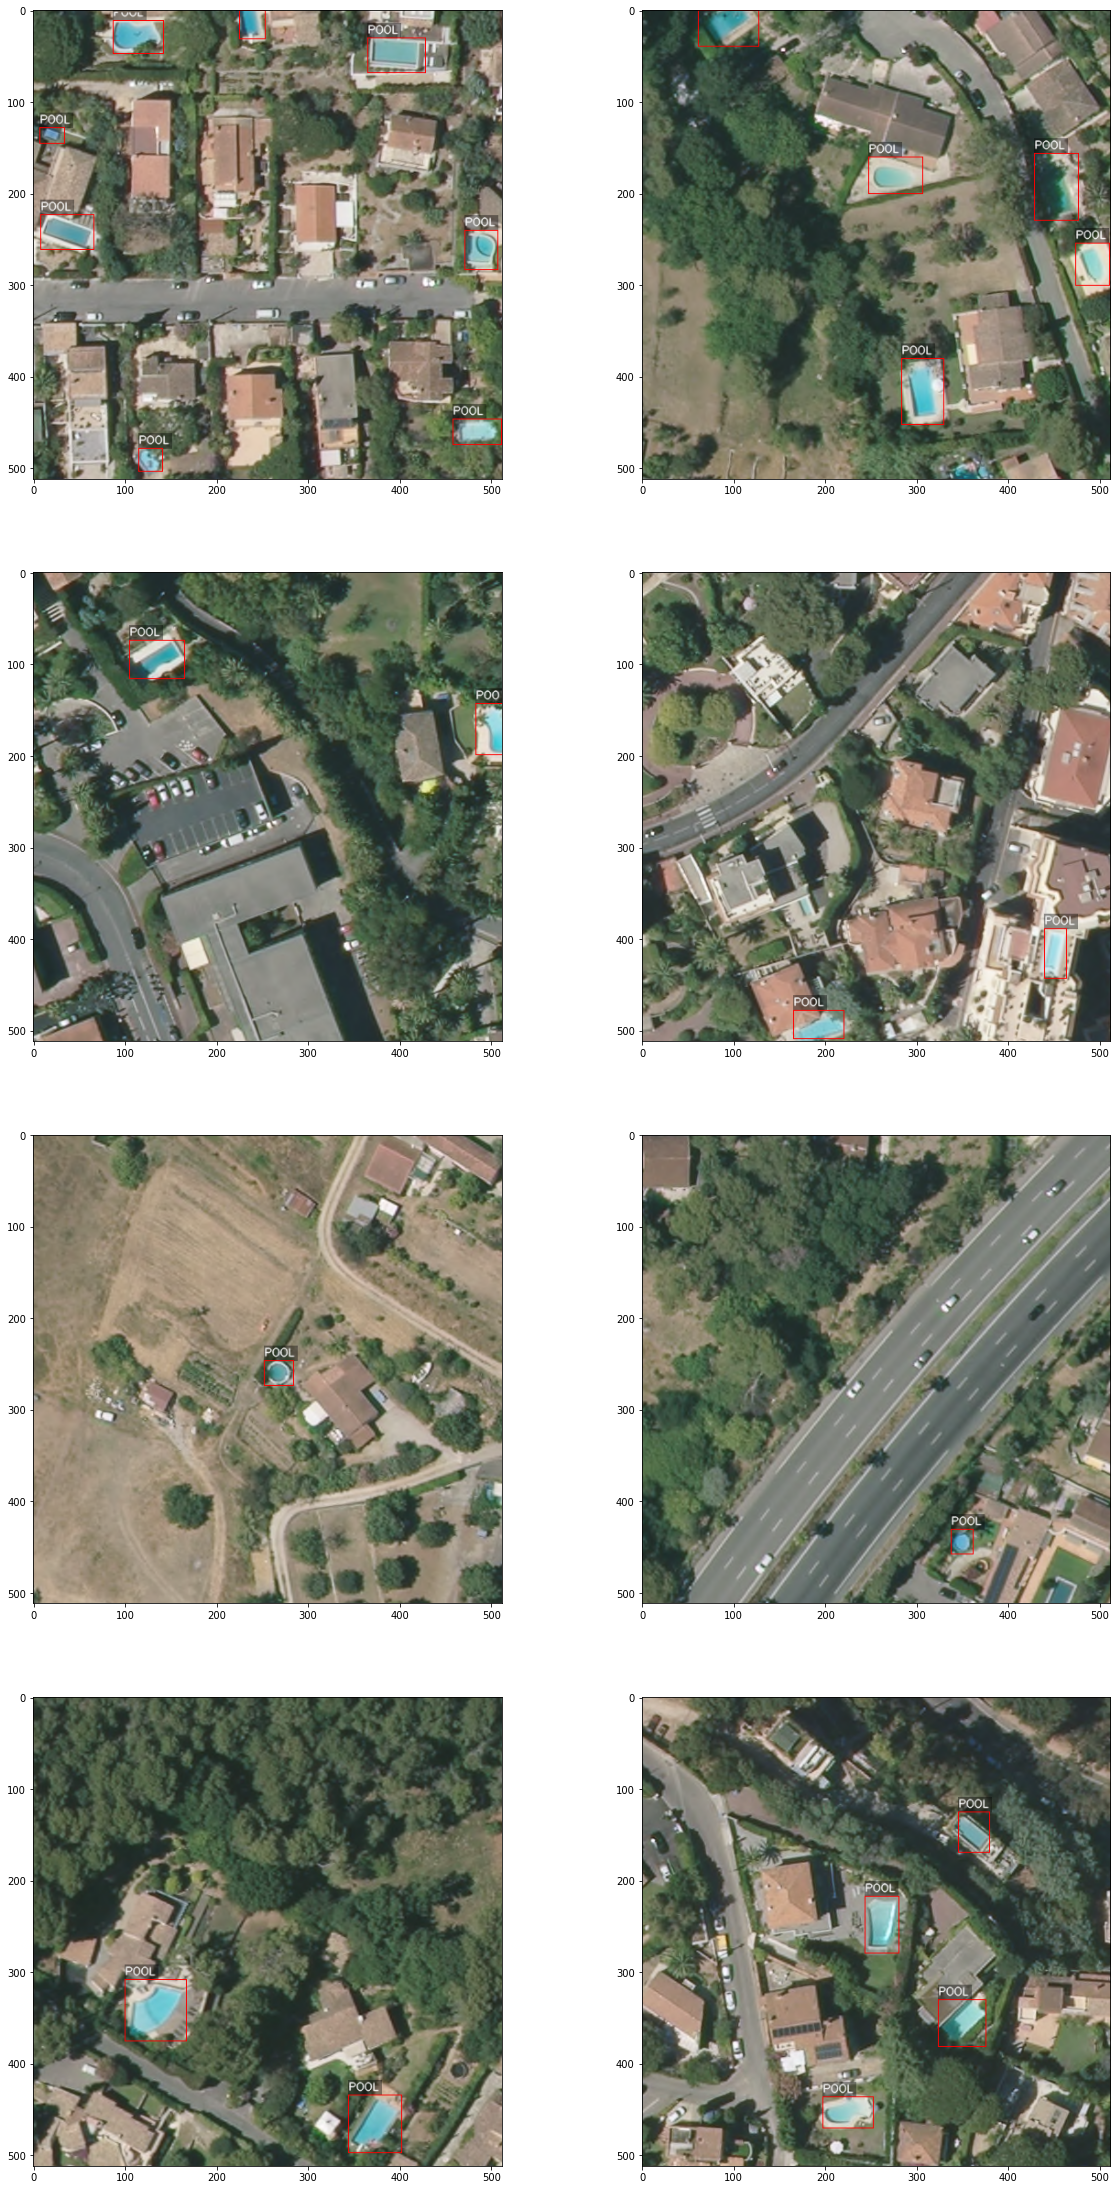

In [ ]:
viz_images = []

for img_id in df_annotations['image_id'].unique()[10:18]:
    img_path = df_annotations[df_annotations['image_id'] == img_id]['image_path'].iloc[0]
    img_array  = cv2.imread(img_path)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    boxes = df_annotations[df_annotations['image_id'] == img_id][['xmin', 'ymin', 'xmax', 'ymax']].to_numpy().tolist()
    labels = df_annotations[df_annotations['image_id'] == img_id][['class']].to_numpy().tolist()
    
    ## Visualize Original Bboxes
    img_before = img_array.copy()
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = (box[0], box[1], box[2], box[3])
        color = label2color[0]
        img_before = draw_bbox_small(img_before, list(np.int_(box)), viz_labels[0], color)
    viz_images.append(img_before)
        
plot_imgs(viz_images)
plt.show()

In [ ]:
warnings.filterwarnings("ignore")

# Training configuration
class TrainGlobalConfig:
    def __init__(self):
        self.num_classes = 1
        self.num_workers = 2
        self.batch_size = 8
        self.n_epochs = 5
        self.lr = 0.001
        self.model_name = 'tf_efficientdet_d1'
        self.folder = 'training_job'
        self.verbose = True
        self.verbose_step = 1
        self.step_scheduler = False
        self.validation_scheduler = True
        self.n_img_count = len(df_annotations.image_id.unique())
        self.OptimizerClass = torch.optim.AdamW
        self.SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
        self.scheduler_params = dict(
            mode='min',
            factor=0.5,
            patience=1,
            verbose=False, 
            threshold=0.0001,
            threshold_mode='abs',
            cooldown=0, 
            min_lr=1e-8,
            eps=1e-08
        )
        self.kfold = 3
    
    def reset(self):
        self.OptimizerClass = torch.optim.AdamW
        self.SchedulerClass = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts

# Training configuration
train_config = TrainGlobalConfig()

## Training will resume if the checkpoint path is specified below
checkpoint_path = None

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

# Run training
fold_history = []
val_fold = 0

for val_fold in range(train_config.kfold):

    print(f'Fold {val_fold+1}/{train_config.kfold}')

    train_ids = df_annotations[df_annotations['fold'] != val_fold].image_id.unique()
    val_ids = df_annotations[df_annotations['fold'] == val_fold].image_id.unique()

    # Create dataset
    train_dataset = DatasetRetriever(
                        image_ids=train_ids,
                        marking=df_annotations,
                        transforms=get_train_transforms(),
                        test=False,
                        )

    validation_dataset = DatasetRetriever(
                            image_ids=val_ids,
                            marking=df_annotations,
                            transforms=get_valid_transforms(),
                            test=True,
                            )

    # Create dataloader
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_config.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=train_config.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=train_config.batch_size,
        num_workers=train_config.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    base_config = get_efficientdet_config(train_config.model_name)
    base_config.image_size = (IMG_SIZE, IMG_SIZE)

    if(checkpoint_path):
        print(f'Resuming from checkpoint: {checkpoint_path}')        
        model = create_model_from_config(base_config, bench_task='train', bench_labeler=True,
                                 num_classes=train_config.num_classes,
                                 pretrained=False)
        model.to(device)

        fitter = Fitter(model=model, device=device, config=train_config, fold=val_fold)
        fitter.load(checkpoint_path)

    else:
        model = create_model_from_config(base_config, bench_task='train', bench_labeler=True,
                                     pretrained=True,
                                     num_classes=train_config.num_classes)
        model.to(device)

        fitter = Fitter(model=model, device=device, config=train_config, fold=val_fold)  

    model_config = model.config
    history_dict = fitter.fit(train_loader, val_loader)
    fold_history.append(history_dict)
    
    #break

Fold 1/3
Fitter prepared. Device is cuda:0

2022-01-13T09:02:48.457560
LR: 0.001


  0%|          | 0/102 [00:00<?, ?it/s]

[RESULT]: Train. Epoch: 0, summary_loss: 0.57945, time: 112.81760


  0%|          | 0/51 [00:00<?, ?it/s]

[RESULT]: Val. Epoch: 0, summary_loss: 0.49569, time: 19.39715

2022-01-13T09:05:11.797273
LR: 0.001


  0%|          | 0/102 [00:00<?, ?it/s]

[RESULT]: Train. Epoch: 1, summary_loss: 0.46421, time: 114.47484


  0%|          | 0/51 [00:00<?, ?it/s]

[RESULT]: Val. Epoch: 1, summary_loss: 0.39378, time: 19.13478

2022-01-13T09:07:26.310768
LR: 0.001


  0%|          | 0/102 [00:00<?, ?it/s]

[RESULT]: Train. Epoch: 2, summary_loss: 0.44113, time: 113.94001


  0%|          | 0/51 [00:00<?, ?it/s]

[RESULT]: Val. Epoch: 2, summary_loss: 0.38777, time: 19.54161

2022-01-13T09:09:40.831911
LR: 0.001


  0%|          | 0/102 [00:00<?, ?it/s]

[RESULT]: Train. Epoch: 3, summary_loss: 0.42206, time: 115.97275


  0%|          | 0/51 [00:00<?, ?it/s]

[RESULT]: Val. Epoch: 3, summary_loss: 0.36575, time: 19.50775

2022-01-13T09:11:57.405128
LR: 0.001


  0%|          | 0/102 [00:00<?, ?it/s]

[RESULT]: Train. Epoch: 4, summary_loss: 0.41199, time: 113.59058


  0%|          | 0/51 [00:00<?, ?it/s]

[RESULT]: Val. Epoch: 4, summary_loss: 0.42280, time: 19.39720
Fold 2/3
Fitter prepared. Device is cuda:0

2022-01-13T09:14:11.548834
LR: 0.001


  0%|          | 0/102 [00:00<?, ?it/s]

[RESULT]: Train. Epoch: 0, summary_loss: 0.57928, time: 114.73701


  0%|          | 0/51 [00:00<?, ?it/s]

[RESULT]: Val. Epoch: 0, summary_loss: 0.55589, time: 19.49029

2022-01-13T09:16:26.693361
LR: 0.001


  0%|          | 0/102 [00:00<?, ?it/s]

[RESULT]: Train. Epoch: 1, summary_loss: 0.44512, time: 113.92604


  0%|          | 0/51 [00:00<?, ?it/s]

[RESULT]: Val. Epoch: 1, summary_loss: 0.38163, time: 19.35981

2022-01-13T09:18:40.882360
LR: 0.001


  0%|          | 0/102 [00:00<?, ?it/s]

[RESULT]: Train. Epoch: 2, summary_loss: 0.43114, time: 115.57442


  0%|          | 0/51 [00:00<?, ?it/s]

[RESULT]: Val. Epoch: 2, summary_loss: 0.38558, time: 19.43313

2022-01-13T09:20:56.386776
LR: 0.001


  0%|          | 0/102 [00:00<?, ?it/s]

[RESULT]: Train. Epoch: 3, summary_loss: 0.40821, time: 115.12497


  0%|          | 0/51 [00:00<?, ?it/s]

[RESULT]: Val. Epoch: 3, summary_loss: 0.39377, time: 19.52233

2022-01-13T09:23:11.524842
LR: 0.0005


  0%|          | 0/102 [00:00<?, ?it/s]

[RESULT]: Train. Epoch: 4, summary_loss: 0.38213, time: 114.19198


  0%|          | 0/51 [00:00<?, ?it/s]

[RESULT]: Val. Epoch: 4, summary_loss: 0.34494, time: 19.50691
Fold 3/3
Fitter prepared. Device is cuda:0

2022-01-13T09:25:26.959521
LR: 0.001


  0%|          | 0/102 [00:00<?, ?it/s]

[RESULT]: Train. Epoch: 0, summary_loss: 0.56744, time: 114.65311


  0%|          | 0/51 [00:00<?, ?it/s]

[RESULT]: Val. Epoch: 0, summary_loss: 0.46038, time: 19.39952

2022-01-13T09:27:41.966542
LR: 0.001


  0%|          | 0/102 [00:00<?, ?it/s]

[RESULT]: Train. Epoch: 1, summary_loss: 0.44302, time: 115.28428


  0%|          | 0/51 [00:00<?, ?it/s]

[RESULT]: Val. Epoch: 1, summary_loss: 0.41103, time: 19.41494

2022-01-13T09:29:57.575811
LR: 0.001


  0%|          | 0/102 [00:00<?, ?it/s]

[RESULT]: Train. Epoch: 2, summary_loss: 0.44449, time: 115.46923


  0%|          | 0/51 [00:00<?, ?it/s]

[RESULT]: Val. Epoch: 2, summary_loss: 0.37346, time: 19.47050

2022-01-13T09:32:13.427072
LR: 0.001


  0%|          | 0/102 [00:00<?, ?it/s]

[RESULT]: Train. Epoch: 3, summary_loss: 0.42700, time: 114.21950


  0%|          | 0/51 [00:00<?, ?it/s]

[RESULT]: Val. Epoch: 3, summary_loss: 0.37875, time: 19.32764

2022-01-13T09:34:27.624021
LR: 0.001


  0%|          | 0/102 [00:00<?, ?it/s]

[RESULT]: Train. Epoch: 4, summary_loss: 0.40830, time: 114.71134


  0%|          | 0/51 [00:00<?, ?it/s]

[RESULT]: Val. Epoch: 4, summary_loss: 0.37652, time: 19.19083


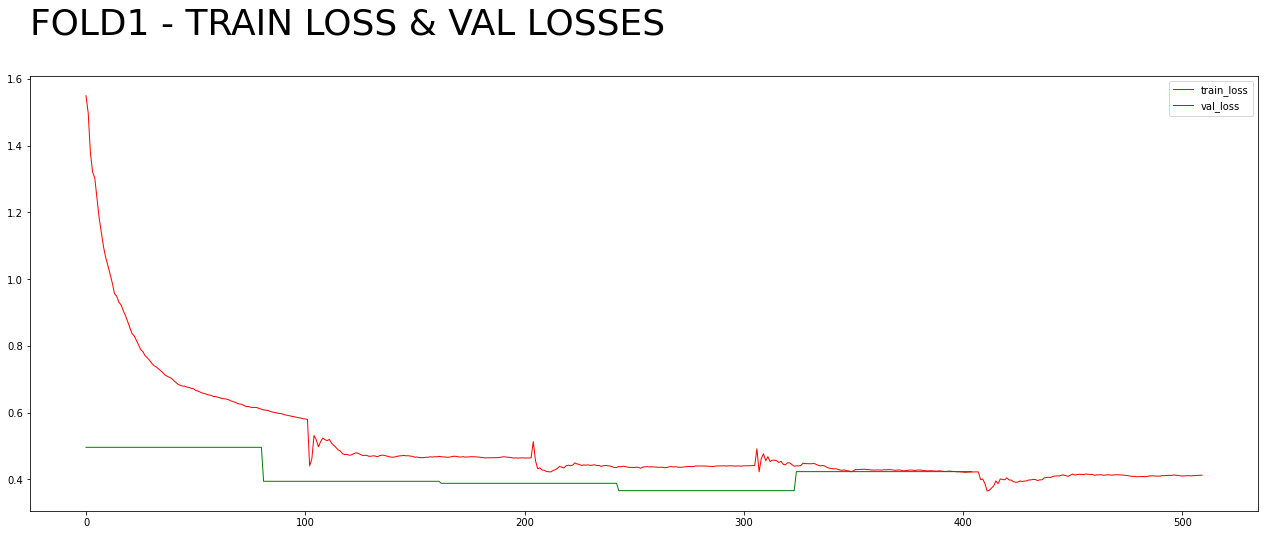

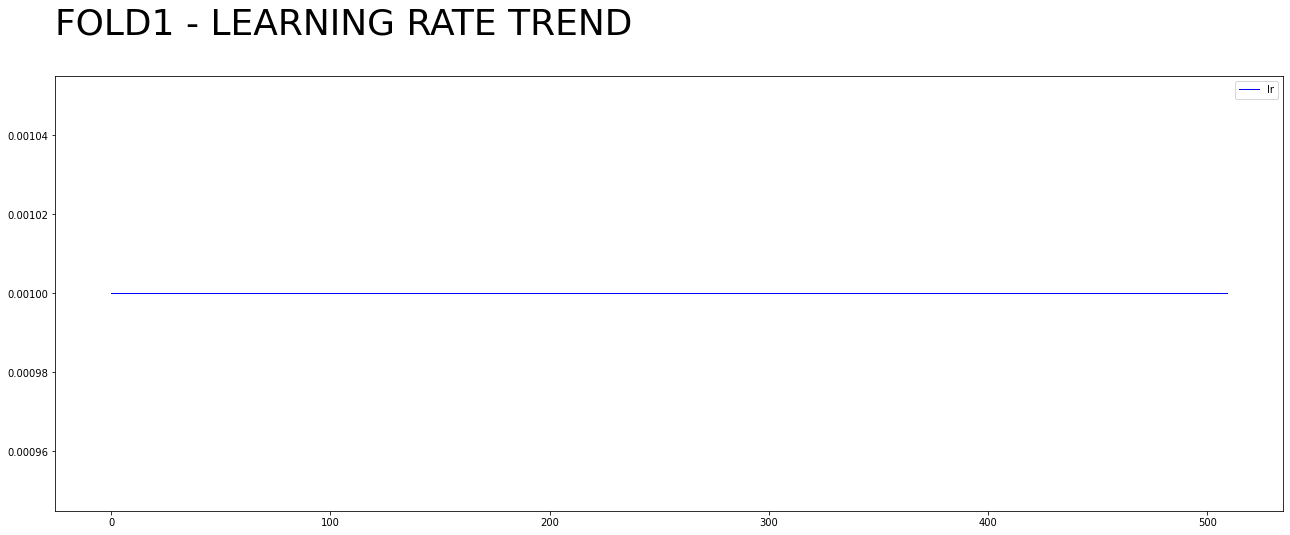

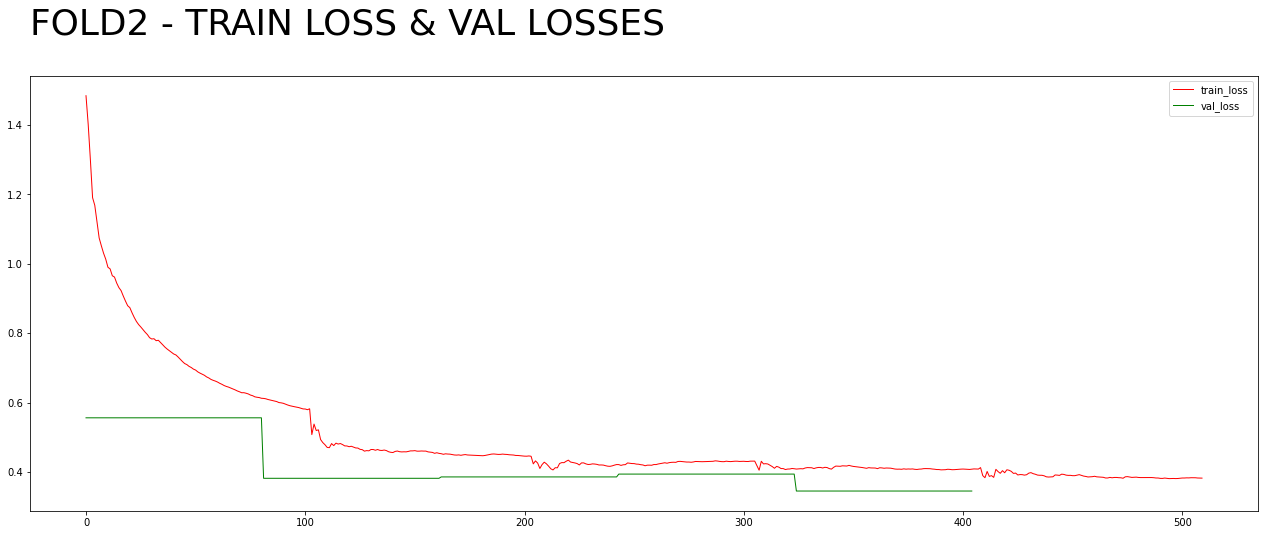

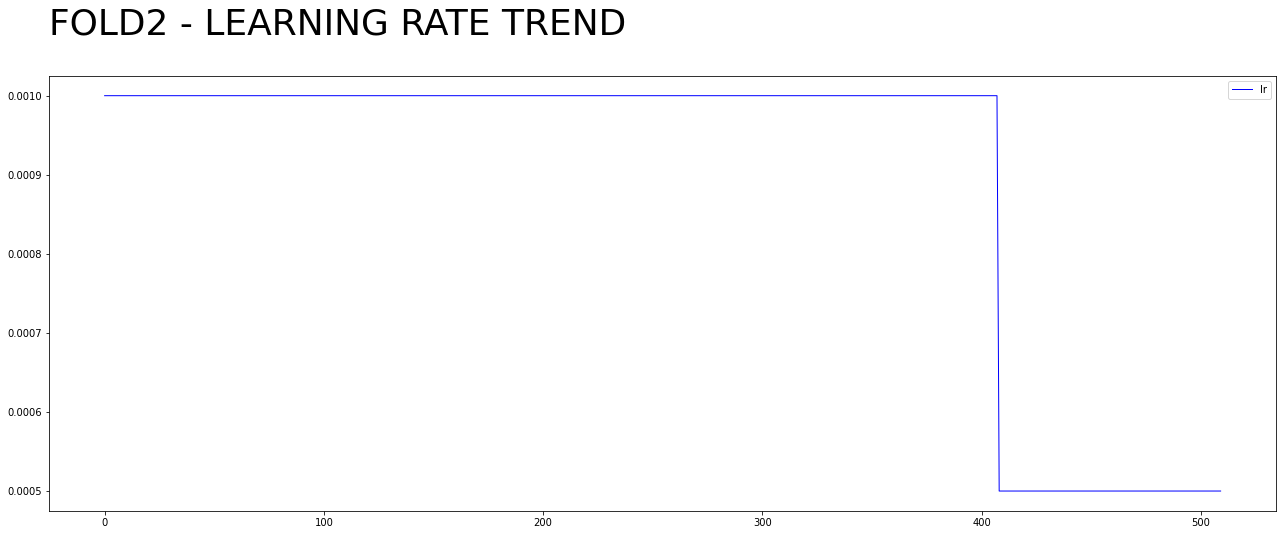

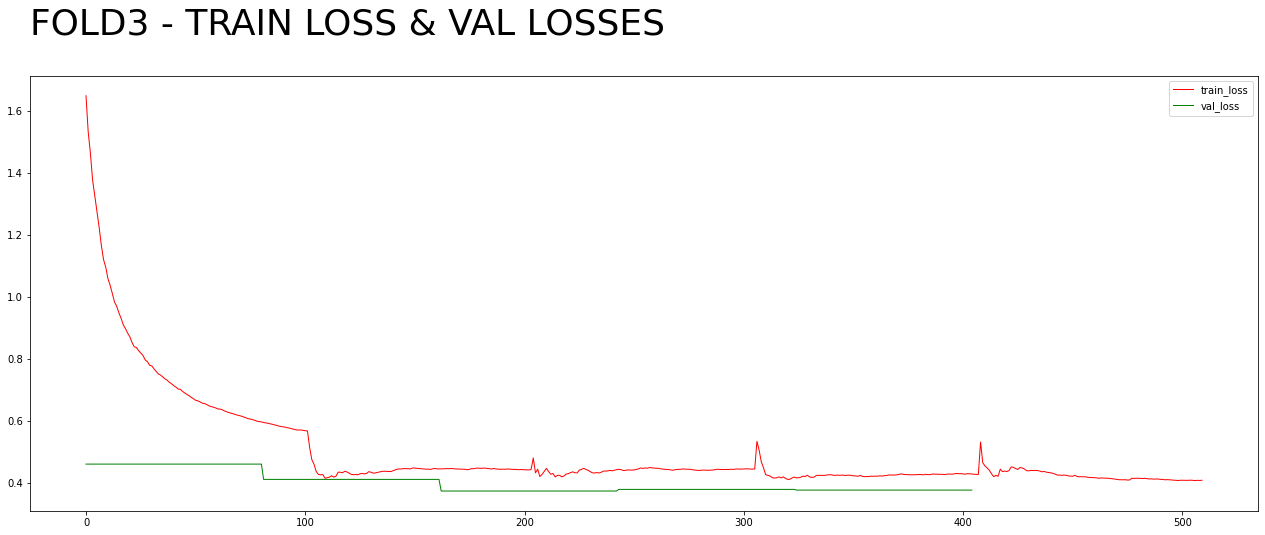

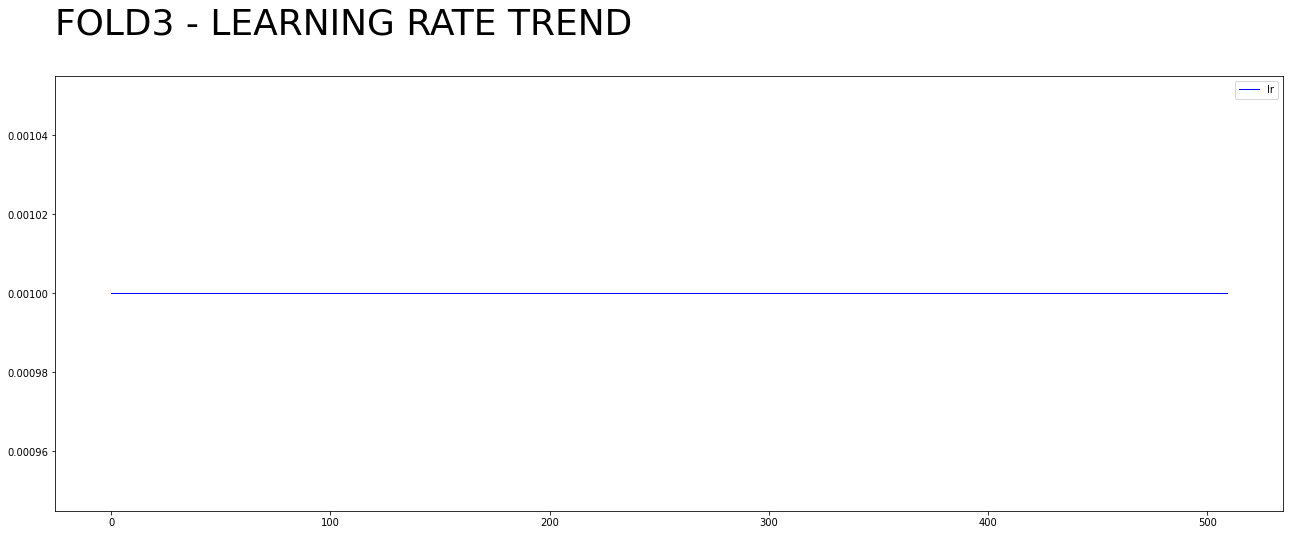

  adding: training_job/fold-0-best-checkpoint-003epoch.bin (deflated 8%)
  adding: training_job/fold-1-best-checkpoint-004epoch.bin (deflated 8%)
  adding: training_job/fold-2-best-checkpoint-002epoch.bin (deflated 8%)
  adding: training_job/last-checkpoint.bin (deflated 8%)
  adding: training_job/log.txt (deflated 78%)


In [ ]:
if TRAIN:
    fold_history_c = fold_history.copy()

    train_loss_all = []
    val_loss_all = []

    n_steps_fold = (train_config.n_img_count//train_config.n_epochs)//train_config.kfold

    for fold, fold_dict in enumerate(fold_history_c):
        train_losses = [item for sublist in fold_dict['train_loss'] for item in sublist]
        val_losses = [item for item in fold_dict['val_loss']]
        train_lrs = [item for sublist in fold_dict['train_lr'] for item in sublist]
        train_loss_all.append(np.array(train_losses))

        val_losses = np.repeat(val_losses, n_steps_fold).tolist()
        val_loss_all.append(np.array(val_losses))

        fig = plt.figure(figsize=(22,8))
        fig.suptitle(f'FOLD{fold+1} - TRAIN LOSS & VAL LOSSES', x=0.125, y=1.00, ha='left',
                     fontweight=100, fontfamily='Lato', size=36)
        plt.plot(train_losses, color='red', label='train_loss', linewidth=1)
        plt.plot(val_losses, color='green', label='val_loss', linewidth=1)
        plt.legend() 
        plt.savefig(f'fold{fold+1}_loss_trend.png', bbox_inches='tight')
        plt.show()

        fig = plt.figure(figsize=(22,8))
        fig.suptitle(f'FOLD{fold+1} - LEARNING RATE TREND', x=0.125, y=1.00, ha='left',
                     fontweight=100, fontfamily='Lato', size=36)
        plt.plot(train_lrs, color='blue', label='lr', linewidth=1)
        plt.legend() 
        plt.savefig(f'fold{fold+1}_lr_trend.png', bbox_inches='tight')
        plt.show()

    # Save weights
    !zip -r training_5folds.zip ./training_job/*

# Evaluate

In [5]:
import sys
import torch
import os
import warnings
import time
import cv2
import random
import gc
import numba
import re
import ast

import pandas as pd
import numpy as np

from tqdm.auto import tqdm
from datetime import datetime
from collections import Counter
from glob import glob

from ensemble_boxes import weighted_boxes_fusion
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from numba import jit
from typing import List, Union, Tuple
from scipy.optimize import linear_sum_assignment

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold, train_test_split
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.utils.data.dataloader import default_collate

from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet import create_model, unwrap_bench, create_loader, create_dataset, create_evaluator, create_model_from_config
from effdet.data import resolve_input_config, SkipSubset
from effdet.anchors import Anchors, AnchorLabeler
from timm.models import resume_checkpoint, load_checkpoint
from timm.optim import create_optimizer
from timm.scheduler import create_scheduler

# Paths
TRAIN_ROOT_PATH = 'Datasets-ML/Aerial Dataset Swimming Pool/CANNES_TILES_512x512_PNG/CANNES_TILES_512x512_PNG/'
TRAIN_LABELS_PATH = 'EDA.csv'

# Models
NFOLDS = 3
MODELS_PATH = []
MODELS_PATH.append('training_job/fold-0-best-checkpoint-003epoch.bin')
MODELS_PATH.append('training_job/fold-1-best-checkpoint-004epoch.bin')
MODELS_PATH.append('training_job/fold-2-best-checkpoint-002epoch.bin')


SEED = 42
IMG_SIZE = 512
PREDS_TH = 0.3

label2color = [[255, 0, 0]]
viz_labels =  ["pool"]

# Load data
df_annotations = pd.read_csv(TRAIN_LABELS_PATH)
df_annotations['image_path'] = df_annotations['image_id'].map(lambda x:os.path.join(TRAIN_ROOT_PATH, str(x)))

# Filter wrong annotations (or too small pools)
df_annotations = df_annotations.drop(df_annotations[(df_annotations['xmin'] == 0) & (df_annotations['xmax'] == 0)].index)
df_annotations = df_annotations.drop(df_annotations[(df_annotations['ymin'] == 0) & (df_annotations['ymax'] == 0)].index)

# Keep only pools
df_annotations = df_annotations[df_annotations['class'] == 'pool']
df_annotations.reset_index(drop=True, inplace=True)
df_annotations['class'] = 1
df_annotations['xmin'] = df_annotations['xmin'] - 1
df_annotations['ymin'] = df_annotations['ymin'] - 1
df_annotations.head(5)

image_id  ...                                         image_path
0  CANNES_TILES_512x512.368.png  ...  Datasets-ML/Aerial Dataset Swimming Pool/CANNE...
1  CANNES_TILES_512x512.110.png  ...  Datasets-ML/Aerial Dataset Swimming Pool/CANNE...
2  CANNES_TILES_512x512.110.png  ...  Datasets-ML/Aerial Dataset Swimming Pool/CANNE...
3   CANNES_TILES_512x512.47.png  ...  Datasets-ML/Aerial Dataset Swimming Pool/CANNE...
4   CANNES_TILES_512x512.47.png  ...  Datasets-ML/Aerial Dataset Swimming Pool/CANNE...

[5 rows x 12 columns]

In [6]:
image_paths = df_annotations['image_path'].unique()
print("Number of Images :",len(image_paths))
anno_count = df_annotations.shape[0]
print("Number of Annotations:", anno_count)

Number of Images : 1224
Number of Annotations: 3197


In [7]:
def calc_stats(gt_boxes, pred_boxes, th=0.5):
    cost_matix = np.ones((len(gt_boxes), len(pred_boxes)))
    for i, box1 in enumerate(gt_boxes):
        for j, box2 in enumerate(pred_boxes):
            iou_score = calculate_iou(box1, box2)
            
            if iou_score < th:
                continue
            else:
                cost_matix[i,j]=0

    row_ind, col_ind = linear_sum_assignment(cost_matix)
    fn = len(gt_boxes) - row_ind.shape[0]
    fp = len(pred_boxes) - col_ind.shape[0]
    tp=0
    for i, j in zip(row_ind, col_ind):
        if cost_matix[i,j]==0:
            tp+=1
        else:
            fp+=1
            fn+=1
    return tp, fp, fn

@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area


def show_result(sample_id, preds, gt_boxes):
    sample = cv2.imread(f'{TRAIN_ROOT_PATH}/{sample_id}', cv2.IMREAD_COLOR)
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for pred_box in preds:
        cv2.rectangle(
            sample,
            (pred_box[0], pred_box[1]),
            (pred_box[2], pred_box[3]),
            (220, 0, 0), 2
        )

    for gt_box in gt_boxes:    
        cv2.rectangle(
            sample,
            (gt_box[0], gt_box[1]),
            (gt_box[2], gt_box[3]),
            (0, 0, 220), 2
        )

    ax.set_axis_off()
    ax.imshow(sample)
    ax.set_title("RED: Predicted | BLUE - Ground-truth")

In [8]:
# Seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Plots
def plot_img(img, size=(18, 18), is_rgb=True, title="", cmap=None):
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=2, size=10, is_rgb=True, title="", cmap=None, img_size=None):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size), constrained_layout=True)
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.axis('off')
        plt.imshow(img)
    plt.suptitle(title)
    return fig

def draw_bbox_small(image, box, label, color):   
    alpha = 0
    alpha_text = 0.4
    thickness = 1
    font_size = 0.4
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, font_size, thickness)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height), (box[0]+text_width+2, box[1]),
                (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_text, output, 1 - alpha_text, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                    color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 255, 255), thickness, cv2.LINE_AA)
    return output
        
# Dataset class
class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()
        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        image, boxes, labels = self.load_image_and_boxes(index)
        
        ## To prevent ValueError: y_max is less than or equal to y_min for bbox from albumentations bbox_utils
        labels = np.array(labels, dtype=np.int).reshape(len(labels), 1)
        combined = np.hstack((boxes.astype(np.int), labels))
        combined = combined[np.logical_and(combined[:,2] > combined[:,0],
                                                          combined[:,3] > combined[:,1])]
        boxes = combined[:, :4]
        labels = combined[:, 4].tolist()
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.tensor(labels)
        target['image_id'] = torch.tensor([index])
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  ## ymin, xmin, ymax, xmax
                    break
            
            ## Handling case where no valid bboxes are present
            if len(target['boxes'])==0 or i==9:
                return None
            else:
                ## Handling case where augmentation and tensor conversion yields no valid annotations
                try:
                    assert torch.is_tensor(image), f"Invalid image type:{type(image)}"
                    assert torch.is_tensor(target['boxes']), f"Invalid target type:{type(target['boxes'])}"
                except Exception as E:
                    print("Image skipped:", E)
                    return None      

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}', cv2.IMREAD_COLOR).copy()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
        labels = records['class'].tolist()
        resize_transform = A.Compose([A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0)], 
                                    p=1.0, 
                                    bbox_params=A.BboxParams(
                                        format='pascal_voc',
                                        min_area=0.1, 
                                        min_visibility=0.1,
                                        label_fields=['labels'])
                                    )

        resized = resize_transform(**{
                'image': image,
                'bboxes': boxes,
                'labels': labels
            })

        resized_bboxes = np.vstack((list(bx) for bx in resized['bboxes']))
        return resized['image'], resized_bboxes, resized['labels']
    
def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=IMG_SIZE, width=IMG_SIZE, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )


def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    
    return tuple(zip(*batch))
            
seed_everything(SEED)

In [9]:
warnings.filterwarnings("ignore")

models = [None] * NFOLDS
preds = [[] for j in range(NFOLDS)]

precision = [None] * NFOLDS
recall = [None] * NFOLDS
f1_score = [None] * NFOLDS

for fold in range(NFOLDS):
    # Validation ids
    val_ids = df_annotations[df_annotations['fold'] == fold].image_id.unique()

    # Creation validation dataset
    validation_dataset = DatasetRetriever(
                            image_ids=val_ids,
                            marking=df_annotations,
                            transforms=get_valid_transforms(),
                            test=True,
                            )

    # Create validation loader
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=4,
        num_workers=1,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    # Load and configure model
    base_config = get_efficientdet_config('tf_efficientdet_d1')
    base_config.image_size = (IMG_SIZE, IMG_SIZE)
    
    models[fold] = create_model_from_config(base_config, 
                                            bench_task='predict', 
                                            num_classes=1,
                                            pretrained=True)

    checkpoint = torch.load(MODELS_PATH[fold])
    models[fold].model.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()
    models[fold].eval()
    models[fold].cuda()
    
    # Loop through validation images
    print('Compute preds for fold', fold)
    ftp, ffp, ffn = [], [], []
    for images, targets, image_ids in tqdm(val_loader, total=len(val_loader)):
        with torch.no_grad():
            images = torch.stack(images)
            images = images.cuda().float()

            target_res = {}
            boxes = [target['boxes'].cuda().float() for target in targets]
            labels = [target['labels'].cuda().float() for target in targets]
            target_res['bbox'] = boxes
            target_res['cls'] = labels 
            target_res["img_scale"] = torch.tensor([1.0] * 8,
                                                   dtype=torch.float).cuda()
            target_res["img_size"] = torch.tensor([images[0].shape[-2:]] * 8,
                                                  dtype=torch.float).cuda()

            det = models[fold](images, target_res)

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4].astype(int)    
                scores = det[i].detach().cpu().numpy()[:,4]
                gt_boxes = (targets[i]['boxes'][:,[1,0,3,2]]).cpu().numpy().astype(int)

                indexes = np.where(scores>0.3)
                pred_boxes = boxes[indexes]
                scores = scores[indexes]

                tp, fp, fn = calc_stats(gt_boxes, pred_boxes, th=0.3)
                ftp.append(tp)
                ffp.append(fp)
                ffn.append(fn)

    tp = np.sum(ftp)
    fp = np.sum(ffp)
    fn = np.sum(ffn)
    precision[fold] = tp / (tp + fp + 1e-6)
    recall[fold] =  tp / (tp + fn +1e-6)
    f1_score[fold] = 2*(precision[fold] *recall[fold])/(precision[fold] +recall[fold]+1e-6)
    
    print(f'TP: {tp}, FP: {fp}, FN: {fn}, PRECISION: {precision[fold] :.4f}, RECALL: {recall[fold]:.4f}, F1 SCORE: {f1_score[fold]:.4f} \n \n')
    
print(f'OOF -  PRECISION: {np.mean(precision) :.4f}, RECALL: {np.mean(recall):.4f}, F1 SCORE: {np.mean(f1_score):.4f}')

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d1_40-a30f94af.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientdet_d1_40-a30f94af.pth


Compute preds for fold 0


  0%|          | 0/102 [00:00<?, ?it/s]

TP: 1041, FP: 218, FN: 25, PRECISION: 0.8268, RECALL: 0.9765, F1 SCORE: 0.8955 
 

Compute preds for fold 1


  0%|          | 0/102 [00:00<?, ?it/s]

TP: 1012, FP: 141, FN: 54, PRECISION: 0.8777, RECALL: 0.9493, F1 SCORE: 0.9121 
 

Compute preds for fold 2


  0%|          | 0/102 [00:00<?, ?it/s]

TP: 1007, FP: 155, FN: 58, PRECISION: 0.8666, RECALL: 0.9455, F1 SCORE: 0.9044 
 

OOF -  PRECISION: 0.8571, RECALL: 0.9571, F1 SCORE: 0.9040
